In [1]:
import pandas as pd
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI

In [2]:
# Load Data
training_df = pd.read_excel("Cleaned_Course_Masterlist_Info.xlsx")
training_df.sample(5)

,Course_ID,Course_Title,Course_Description,Category,Course_Cert,Course_Supplier,Course_SupplierNGPS,Course_Modality,Course_Country,Is_Overseas,...,SGDCostperpax_24_25,SGDCostperpax_25_26,Q1,Q2,Q3,Q4,Available_Quarters,Start_Date,End_Date,Available_Dates
234,HTB-SAP,Silver Annual Plan,Elevate your skills with our Silver Annual Pla...,Technology Foundations,NaN,Hack the Box,NaN,NaN,NaN,NaN,...,NaN,700.0,Q1,NaN,NaN,NaN,Q1,2025-04-01,2025-06-30,01 Apr 2025 - 30 Jun 2025
235,ECABS,Executive Certificate in Applied Behavioural S...,Elevate your leadership and management skills ...,-Language,Executive Certificate in Applied Behavioural S...,SMU,NaN,NaN,NaN,NaN,...,NaN,1962.0,Q1,NaN,NaN,NaN,Q1,NaT,NaT,0
197,CT1006,Blockchain for Finance: Using Blockchain & Sma...,Dive into the transformative world of blockcha...,Cyber Security,NaN,Udemy,NaN,NaN,NaN,NaN,...,NaN,NaN,Q1,NaN,NaN,NaN,Q1,2025-04-01,2025-06-30,01 Apr 2025 - 30 Jun 2025
103,WCA6-2M,Post-grad Diploma in Digital Marketing,Elevate your digital marketing skills with our...,Technology Foundations,NaN,M.A.D. School,NaN,NaN,NaN,NaN,...,13000.0,13000.0,Q1,NaN,NaN,NaN,Q1,2025-04-01,2025-06-30,01 Apr 2025 - 30 Jun 2025
176,WCA2004,Social Media/Network Investigation and Intelli...,Delve into the world of Social Media/Network I...,OSINT,NaN,Udemy,NaN,NaN,NaN,NaN,...,NaN,NaN,Q1,NaN,NaN,NaN,Q1,2025-04-01,2025-06-30,01 Apr 2025 - 30 Jun 2025


In [3]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine

engine = create_engine("sqlite:///training.db")
training_df.to_sql("training", engine, index=False)

ValueError: Table 'training' already exists.

In [4]:
db = SQLDatabase(engine=engine)
print(db.dialect)
print(db.get_usable_table_names())
print(db.run("SELECT * FROM training WHERE SGDCostperpax_25_26 > 1000;"))

sqlite
['training']
[('A074', 'ISS World Europe', 'Dive into the dynamic world of ISS (Intelligent Space Systems) with ISS World Europe. This comprehensive training course covers the latest advancements in space technology, mission planning, and operational strategies. Ideal for professionals in aerospace, defense, and related industries, this...', 'Cyber Security', None, 'ISS World Training', None, 'In Person', 'Czechoslovakia', 'Overseas', 'Prague', 'Conference/Seminar', 'EA', 'A1-W', 'No', 20.0, None, None, None, None, 7000.0, 6000.0, 6000.0, 'Q1', None, None, None, 'Q1', '2025-04-01 00:00:00.000000', '2025-06-30 00:00:00.000000', '01 Apr 2025 - 30 Jun 2025'), ('A879', 'Australian OSINT Symposium', 'Delve into the world of Open Source Intelligence (OSINT) with the Australian OSINT Symposium. This comprehensive course equips you with the skills to gather, analyze, and interpret publicly available information to inform strategic decision-making. Through practical case studies and expe

In [ ]:
import getpass
import os

#if not os.environ.get("TOGETHER_API_KEY"):
  #os.environ["TOGETHER_API_KEY"] = getpass.getpass("Enter API key for Together AI: ")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    base_url="",
    api_key="",
    model=r"",
)

In [6]:
from langchain_core.prompts.chat import ChatPromptTemplate

# Convert the text template into a ChatPromptTemplate
query_prompt_template = ChatPromptTemplate.from_template(
    '''
    Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

    Never query for all the columns from a specific table, only ask for a few relevant columns given the question.

    The query should be formatted as JSON with a single field "query":

    {{
      "query": "SELECT COUNT(*) FROM Database;"
    }}

    Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

    Only use the following tables:
    {table_info}

    Question: {input}
    '''
)


In [7]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [8]:
from typing_extensions import Annotated



class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [9]:
write_query({"question": "How many category OSINT courses are there?"})

{'query': "SELECT COUNT(*) FROM training WHERE Category = 'OSINT';"}

In [10]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [11]:
execute_query({'query': "SELECT COUNT(*) FROM training WHERE Category = 'OSINT';"})

{'result': '[(51,)]'}

In [12]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

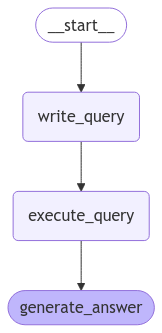

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from pprint import pprint

for step in graph.stream(
    {"question": "list me all the courses in the A1-W domain that can teach me about social media data"}, stream_mode="updates"
):
    pprint(step)

{'write_query': {'query': 'SELECT Course_ID, Course_Title, Course_Description, '
                          'Course_Domain FROM training WHERE Course_Domain = '
                          "'A1-W' AND Course_Description LIKE '%social "
                          "media%';"}}
{'execute_query': {'result': "[('ROA003', 'Web Tech for OSINT Practitioners "
                             "(Basic) Course', 'Dive into the world of web "
                             'technology for Open Source Intelligence (OSINT) '
                             'with our introductory course. Learn how to '
                             'effectively gather, analyze, and interpret '
                             'publicly available information using web tools '
                             'and techniques. Ideal for beginners in OSINT, '
                             "this course covers essential skills in...', "
                             "'A1-W'), ('SEC497', 'Practical Open-Source "
                             "Intel